# Our own depth prediction training and results

In [19]:
import cv2
from PIL import Image as im
from scipy import ndimage as ndi
import h5py
import numpy as np
import scipy.io
from keras.utils.io_utils import HDF5Matrix
import matplotlib.pyplot as plt

In [20]:
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.optimizers import SGD
from keras import backend as K
from PIL import Image
import keras
import tensorflow as tf
from skimage.morphology import watershed
from skimage.feature import peak_local_max

# 0. Make training set

In [8]:
#load data from NYU Depth V2
f = h5py.File('F:/pfe_2/nyu_seg/nyu_depth_v2_labeled.mat', 'r')
for k, v in f.items():
    print(k,'      ',v)

#refs#        <HDF5 group "/#refs#" (8484 members)>
#subsystem#        <HDF5 group "/#subsystem#" (1 members)>
accelData        <HDF5 dataset "accelData": shape (4, 1449), type "<f4">
depths        <HDF5 dataset "depths": shape (1449, 640, 480), type "<f4">
images        <HDF5 dataset "images": shape (1449, 3, 640, 480), type "|u1">
instances        <HDF5 dataset "instances": shape (1449, 640, 480), type "|u1">
labels        <HDF5 dataset "labels": shape (1449, 640, 480), type "<u2">
names        <HDF5 dataset "names": shape (1, 894), type "|O">
namesToIds        <HDF5 dataset "namesToIds": shape (1, 6), type "<u4">
rawDepthFilenames        <HDF5 dataset "rawDepthFilenames": shape (1, 1449), type "|O">
rawDepths        <HDF5 dataset "rawDepths": shape (1449, 640, 480), type "<f4">
rawRgbFilenames        <HDF5 dataset "rawRgbFilenames": shape (1, 1449), type "|O">
sceneTypes        <HDF5 dataset "sceneTypes": shape (1, 1449), type "|O">
scenes        <HDF5 dataset "scenes": shape (1, 14

## 0.1 make different data set 
#### 0.1.1 resize the data base
#### 0.1.1 crop the data base to augment data base 
further data augementation can be down with random crop, and random flip left and right, change the illumination or so on. 

In [ ]:
def exchange(X):
    nX = np.reshape(X, (X.shape[0], 640,480,3))
    for i in range(len(X)):
        for j in range(3):
            nX[i][:,:,j] = X[i][j,:,:]
    return nX

def resize_set(dset,width = 320,height = 240,n =3):
    new = np.zeros([len(dset),width,height,n],dtype=np.uint8)
    for i in range(len(dset)):
        img = dset[i].reshape(640,480,n)
        img = im.fromarray(img.astype('uint8'))
        img = img.resize([height,width], im.ANTIALIAS)
        new[i] = img
    return new

def resize_testset(dset,width = 320,height = 240,n = 10):
    new = np.zeros([len(dset),width,height],dtype=np.uint8)
    for i in range(len(dset)):
        img = (dset[i]*(255/n)).reshape(640,480)
        img = im.fromarray(img.astype('uint8'))
        img = img.resize([height,width],im.ANTIALIAS)
        new[i] = img
    return new

def crop_set(dset, dim=3):
    if dim ==3:
        new = np.zeros([4*len(dset),320,240,dim],dtype=np.uint8)
    if dim ==1 :
        new = np.zeros([4*len(dset),320,240],dtype=np.uint8)
    for i in range(len(dset)):
        img = dset[i]
        if dim == 3:
            new[4*i] = img[0:320,0:240,:]
            new[4*i+1] = img[320:640,0:240,:]
            new[4*i+2] = img[0:320,240:480,:]
            new[4*i+3] = img[320:640,240:480,:]
        else:
            new[4*i] = img[0:320,0:240]
            new[4*i+1] = img[320:640,0:240]
            new[4*i+2] = img[0:320,240:480]
            new[4*i+3] = img[320:640,240:480]
    return new

# 1. Load the data set
load the cropped data to train

In [16]:
filename = 'croped_seg.mat'
X_train = HDF5Matrix(filename, 'images', start=0, end=1300*4)
y_train = HDF5Matrix(filename, 'depths', start=0, end=1300*4)
y_train = np.expand_dims(np.asarray(y_train), axis = 3)
X_test = HDF5Matrix(filename, 'images', start=1300*4, end=1448*4)
y_test = HDF5Matrix(filename, 'depths', start=1300*4, end=1448*4)
#X_test = X_test.resize([X_test.shape[0],224,224,3])
y_test = np.expand_dims(np.asarray(y_test), axis = 3)

In [17]:
print('the shape of training set is : ',np.shape(X_train))
print('the shape of training ground truth is : ',np.shape(y_train))
print('the length of test set is : ',np.shape(X_test)[0])

the shape of training set is :  (5200, 224, 224, 3)
the shape of training ground truth is :  (5200, 112, 112, 1)
the length of test set is :  592


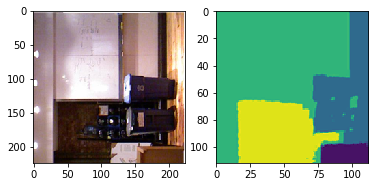

In [11]:
plt.figure(1)
plt.subplot(121);plt.imshow(X_train[110])
plt.subplot(122);plt.imshow(y_train[110][:,:,0])
plt.show()

# 2. Build the model

## 2.1 use resnet 50 pretrained with imagenet as our base line

In [7]:
# create the base pre-trained model
# inceptionV3 default input 299*299
#base_model = InceptionV3(weights='imagenet', include_top=False)
base_model = ResNet50(weights='imagenet')

## 2.2 create our own upsampling method

In [8]:
def up_pool(x, fil, relu=True):
    outputA = keras.layers.Conv2D(filters = fil, kernel_size= 3, padding = 'same',kernel_initializer = 'random_normal',
                                     bias_initializer = 'random_normal',strides= 1 , activation = 'linear')(x)
    outputB = keras.layers.Conv2D(filters = fil, kernel_size= 3, padding = 'same',kernel_initializer = 'random_normal',
                                     bias_initializer = 'random_normal',strides= 1 , activation = 'linear')(x)
    outputC = keras.layers.Conv2D(filters = fil, kernel_size= 3, padding = 'same',kernel_initializer = 'random_normal',
                                     bias_initializer = 'random_normal',strides= 1 , activation = 'linear')(x)
    outputD = keras.layers.Conv2D(filters = fil, kernel_size= 3, padding = 'same',kernel_initializer = 'random_normal',
                                     bias_initializer = 'random_normal',strides= 1 , activation = 'linear')(x)
    left = keras.layers.Concatenate(axis=1)([outputA, outputB])
    right = keras.layers.Concatenate(axis=1)([outputC, outputD])
    Y = keras.layers.Concatenate(axis=2)([left, right])
    Y = keras.layers.BatchNormalization()(Y)
    if relu:
        Y = keras.layers.Activation('relu')(Y)  
    return Y

In [9]:
def up_sampleo(x, fil):
    x1 = up_pool(x, fil)
    x2 = up_pool(x, fil,False)
    x1 = keras.layers.BatchNormalization()(x1)
    x = keras.layers.Add()([x1, x2])
    x = keras.layers.Activation('relu')(x)
    return x

In [10]:
def up_sample(x,fil):
    x1 = keras.layers.Conv2DTranspose(filters = fil, kernel_size= 3, padding = 'valid', kernel_initializer = 'random_normal',
                               bias_initializer = 'random_normal',strides= 2 , activation = 'linear')(x)
    x2 = keras.layers.Conv2DTranspose(filters = fil, kernel_size= 3, padding = 'valid', kernel_initializer = 'random_normal',
                               bias_initializer = 'random_normal',strides= 2 , activation = 'relu')(x)
    x1 = keras.layers.BatchNormalization()(x1)
    x = keras.layers.Add()([x1, x2])
    x = keras.layers.Activation('relu')(x)
    return x

In [11]:
def huber_loss(y_true, y_pred, clip_delta=1.0):
    error = y_true - y_pred
    cond  = tf.keras.backend.abs(error) < clip_delta

    squared_loss = 0.5 * tf.keras.backend.square(error)
    linear_loss  = clip_delta * (tf.keras.backend.abs(error) - 0.5 * clip_delta)
    return tf.keras.backend.mean(tf.where(cond, squared_loss, linear_loss))

In [12]:
def add_layer(x, base_model,layer_name, fil,temp):
    mixed2 = base_model.get_layer(layer_name).output
    mixed2 =  keras.layers.Cropping2D(cropping=temp)(mixed2)
    mixed2 = keras.layers.Conv2D(filters = fil, kernel_size= 1, padding = 'valid',
                                strides= 1 , activation = 'relu')(mixed2)
    mixed2 = keras.layers.BatchNormalization()(mixed2)
    x = keras.layers.Add()([x, mixed2])
    return x

## 2.3 Build the model 
using multi outputs of resnet baseline, and using a pyramid structure to use these information.

combining information of different scale level, then upsamling to our final prediction. 

In [115]:
dropout_rate = 0.3
x = base_model.get_layer('activation_46').output
x = up_sampleo(x,512)
# 14,14,512
x1 = base_model.get_layer('activation_40').output
x1 = keras.layers.Conv2D(filters = 512,  kernel_size= 3, padding = 'same',kernel_initializer = 'random_normal',
                                     bias_initializer = 'random_normal',strides= 1 , activation = 'relu')(x1)
x = keras.layers.Add()([x1, x])

x = up_sampleo(x,256)
#28,28,256
x2 = base_model.get_layer('activation_22').output
x2 = keras.layers.Conv2D(filters = 256,  kernel_size= 3, padding = 'same',kernel_initializer = 'random_normal',
                                     bias_initializer = 'random_normal',strides= 1 , activation = 'relu')(x2)
x = keras.layers.Add()([x2, x])

x = up_sampleo(x,128)
#56,56,128

x = up_sampleo(x,64)
#112,112,64

x = keras.layers.Dropout(rate = dropout_rate)(x)

x = keras.layers.Conv2D(filters = 1,  kernel_size= 3, padding = 'same',kernel_initializer = 'random_normal',
                                     bias_initializer = 'random_normal',strides= 1 , activation = 'relu')(x)
#predictions = keras.layers.BatchNormalization()(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

epochs = 50
learning_rate = 0.01
decay_rate = 5e-6
momentum = 0.9
sgd = SGD(lr=learning_rate,momentum=momentum, decay=decay_rate, nesterov=False)

model.compile(optimizer=sgd, loss=huber_loss)

## 2.4  Train the model
with SGD which is able to get a better result.
set batch size as 16, and use a learning rate decay rate.

In [37]:
batchsize = 16
epoch = 1

# we create two instances with the same arguments
data_gen_args = dict(featurewise_center=True,
                     featurewise_std_normalization=True,
                     rotation_range=90.,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     zoom_range=0.2,
                     vertical_flip=True
                     #,zca_whitening=True
                    )

image_datagen = image.ImageDataGenerator(**data_gen_args)
mask_datagen = image.ImageDataGenerator(**data_gen_args)

# Provide the same seed and keyword arguments to the fit and flow methods
seed = 1
image_datagen.fit(X_train, augment=True, seed=seed)
mask_datagen.fit(y_train, augment=True, seed=seed)

image_generator = image_datagen.flow(X_train,y_train, batch_size=batchsize, seed=seed)

In [39]:
cbb = keras.callbacks.TensorBoard(log_dir='./Graph2', histogram_freq =0, write_graph=True, write_images=True)

Instructions for updating:
Use the retry module or similar alternatives.


In [ ]:
model.fit_generator(image_generator, callbacks=[cbb],steps_per_epoch=500, epochs=50)

In [73]:
# evaluate the model
scores = model.evaluate(X_test, y_test, verbose=0)
scores

218.92913949148996

### 2.4 save model as json

In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

# 3.  Tester our model

## 3.1 load model

In [3]:
# load json and create model
json_file = open('model/org/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = keras.models.model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model/org/model.h5")
print("Loaded model from disk")

Loaded model from disk


In [135]:
def get_out(img20, trans=False):
    img20 = cv.resize(img20, (224, 224))
    if trans:
        for j in range(3):
            img20[:,:,j] = img20[:,:,j].T
    
    img20 = np.expand_dims(np.asarray(img20), axis = 0)

    y = loaded_model.predict(img20)
    y=np.array(y)
    ss = np.int(np.sqrt(np.size(y)))
    y=np.reshape(y,(ss,ss))
    return y

## 3.2 Try to refine the prediction with image morphology

In [93]:
def morph_open(img):
    kernel = np.ones((10,10),np.uint8)
    img = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
    #img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
    return img

In [94]:
def morph_close(img):
    kernel = np.ones((10,10),np.uint8)
    #img = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
    img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
    return img

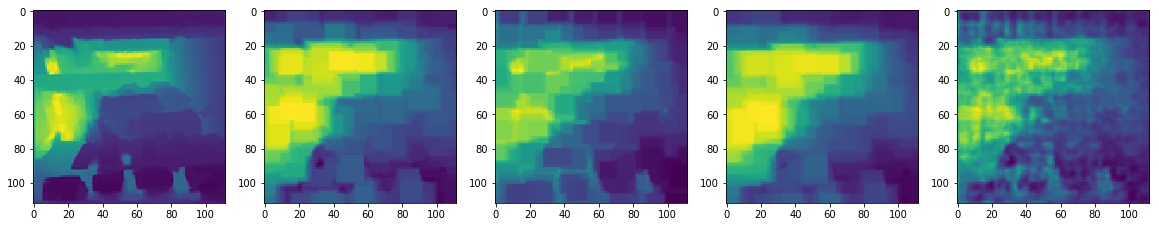

In [175]:
i = 89
imgg = X_train[i]
plt.rcParams['figure.figsize'] = [20, 20]
plt.subplot(151);plt.imshow(y_train[i][:,:,0])

iii =get_out(imgg)
iiii1 = morph_open(iii)
plt.subplot(152);plt.imshow(iiii1)

iiii2 = morph_close(iii)
plt.subplot(153);plt.imshow(iiii2)

iiii = (iiii1 + iiii2)/2
iiii = morph_open(iiii)
plt.subplot(154);plt.imshow(iiii)

plt.subplot(155);plt.imshow(iii)
plt.show()

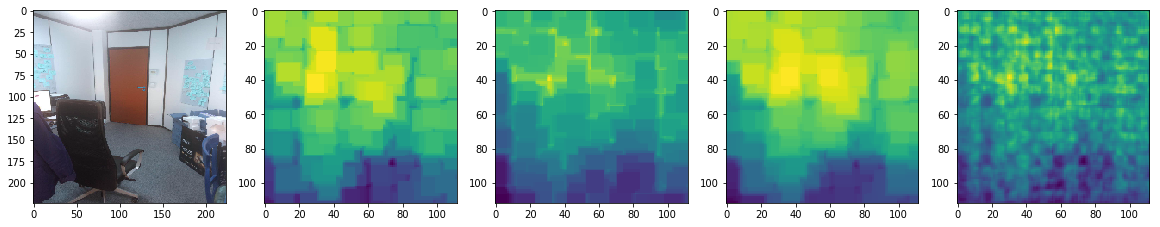

In [149]:
img20 = cv.imread('cv/t1.jpg')
img20 = cv.resize(img20, (224, 224))
plt.subplot(151);plt.imshow(img20)

plt.subplot(152)
iii =get_out(img20,True)
iiii1 = morph_open(iii)
plt.imshow(iiii1.T)

iiii2 = morph_close(iii)
plt.subplot(153);plt.imshow(iiii2.T)

iiii = (iiii1 + iiii2)/2
iiii = morph_open(iiii)
plt.subplot(154);plt.imshow(iiii.T)
plt.subplot(155);plt.imshow(iii.T)
plt.show()

## 3.3 try to use watershed example

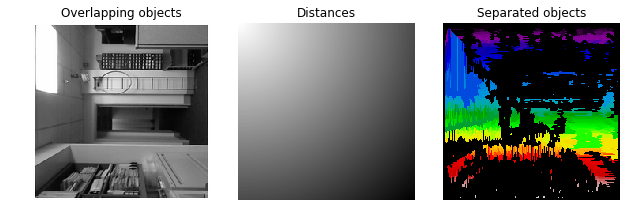

In [128]:
i = 16
image = X_train[i]
image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
distance = ndi.distance_transform_edt(image)
local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3, 3)),
                            labels=image)
markers = ndi.label(local_maxi)[0]
labels = watershed(-distance, markers, mask=image)
fig, axes = plt.subplots(ncols=3, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel()
ax[0].imshow(image, cmap=plt.cm.gray, interpolation='nearest')
ax[0].set_title('Overlapping objects')
ax[1].imshow(-distance, cmap=plt.cm.gray, interpolation='nearest')
ax[1].set_title('Distances')
ax[2].imshow(labels, cmap=plt.cm.nipy_spectral, interpolation='nearest')
ax[2].set_title('Separated objects')
for a in ax:
    a.set_axis_off()

fig.tight_layout()
plt.show()

[0] Long, Jonathan, Evan Shelhamer, and Trevor Darrell. "Fully convolutional networks for semantic segmentation." Proceedings of the IEEE conference on computer vision and pattern recognition. 2015.

[1] Peng, Chao, et al. "Large kernel matters—improve semantic segmentation by global convolutional network." Computer Vision and Pattern Recognition (CVPR), 2017 IEEE Conference on. IEEE, 2017.

[2] Lin, Tsung-Yi, et al. "Feature Pyramid Networks for Object Detection." CVPR. Vol. 1. No. 2. 2017.